# Анализ успеваемости студентов
Цель проекта:
Исследовать зависимость между временем сдачи домашних заданий и успеваемостью студентов.

Используемые данные:  
- 11 таблиц с информацией о студентах, курсах и выполненных заданиях  
- Период: 2024 учебный год  

In [4]:
#Загрузка библиотек
import pandas as pd
import sqlite3 as sql
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Загрузка данных

Загружаем следующие таблицы:
- `users.csv` - профили пользователей
- `user_roles.csv` - роли пользователей
- `cities.csv` - города проживания пользователей  
- `courses.csv` - информация о курсах
- `course_types.csv` - типы курсов
- `course_users.csv` - связка пользователей и курсов
- `subjects.csv` - предметы, изучаемые на курсах
- `lessons.csv` - информация об уроках
- `homework.csv` - домашние работы
- `homework_done.csv` - сданные домашние работы
- `homework_lessons.csv` - связка домашних работ и уроков

In [5]:
#Загрузка данных
users = pd.read_csv('users.csv')
user_roles = pd.read_csv('user_roles.csv')
cities = pd.read_csv('cities.csv')
courses = pd.read_csv('courses.csv')
course_users = pd.read_csv('course_users.csv')
course_types = pd.read_csv('course_types.csv')
subjects = pd.read_csv('subjects.csv')
lessons = pd.read_csv('lessons.csv')
homework = pd.read_csv('homework.csv')
homework_lessons = pd.read_csv('homework_lessons.csv')
homework_done = pd.read_csv('homework_done.csv')

## 2. Подготовка SQL-базы

Создаем временную базу данных для:
1. Комплексного анализа через SQL-запросы  
2. Объединения таблиц, которые сложно соединить в pandas  
3. Проверки гипотез о взаимосвязях между сущностями  

In [6]:
# Создаём подключение к БД
conn = sql.connect('education.db')

# Загружаем DataFrame в SQL-таблицы
users.to_sql('users', conn, index=False, if_exists='replace')
user_roles.to_sql('user_roles', conn, index=False, if_exists='replace')
cities.to_sql('cities', conn, index=False, if_exists='replace')
courses.to_sql('courses', conn, index=False, if_exists='replace')
course_users.to_sql('course_users', conn, index=False, if_exists='replace')
course_types.to_sql('course_types', conn, index=False, if_exists='replace')
subjects.to_sql('subjects', conn, index=False, if_exists='replace')
lessons.to_sql('lessons', conn, index=False, if_exists='replace')
homework.to_sql('homework', conn, index=False, if_exists='replace')
homework_lessons.to_sql('homework_lessons', conn, index=False, if_exists='replace')
homework_done.to_sql('homework_done', conn, index=False, if_exists='replace')

58400

## 3. Проверка гипотезы о влиянии скорости сдачи ДЗ

**Гипотеза:**  
Студенты, сдающие ДЗ в течение 48 часов после урока, показывают результаты на 8.5 баллов выше (p < 0.001).

**Метод проверки:**  
1. Классифицируем студентов на 3 группы по скорости сдачи:  
   - "Быстрые" (≤2 дней)  
   - "Стандартные" (2-5 дней)  
   - "Медлительные" (>5 дней)  
2. Сравниваем средние баллы между группами  
3. Визуализируем распределение оценок  




In [9]:
#SQL-запрос для анализа
query = '''
        SELECT u.id AS student_id,
               -- Среднее время сдачи ДЗ по всем урокам
               ROUND(AVG(julianday(hd.created_at) - julianday(l.date)), 2) AS avg_days_to_complete,
                -- Средний балл студента
               AVG(CASE WHEN hd.mark IS NOT NULL THEN hd.mark ELSE 0 END) AS avg_mark,
               CASE -- Категория "быстрый/стандартный/медлительный"
                   WHEN AVG(julianday(hd.created_at) - julianday(l.date)) <= 2 THEN 'быстрый'
                   WHEN AVG(julianday(hd.created_at) - julianday(l.date)) > 5 THEN 'медлительный'
                   ELSE 'стандартный' END AS student_type
        FROM user_roles ur INNER JOIN users u ON ur.id = u.user_role_id
                           INNER JOIN homework_done hd ON u.id = hd.user_id
                           INNER JOIN homework_lessons hl ON hd.homework_id = hl.homework_id
                           INNER JOIN lessons l ON l.id = hl.lesson_id
        WHERE ur.name = 'student'
        GROUP BY user_id  -- Группируем по студентам
        ;
'''
# Загружаем полученную таблицу в переменную df
df = pd.read_sql(query, conn)

In [12]:
# Вычисляем предварительные наблюдения
print(f"Всего студентов: {len(df)}")
print(f"Быстрые: {sum(df['student_type'] == 'быстрый')}")
print(f"Стандартные: {sum(df['student_type'] == 'стандартный')}")
print(f"Медлительные: {sum(df['student_type'] == 'медлительный')}")

Всего студентов: 3246
Быстрые: 128
Стандартные: 896
Медлительные: 2222


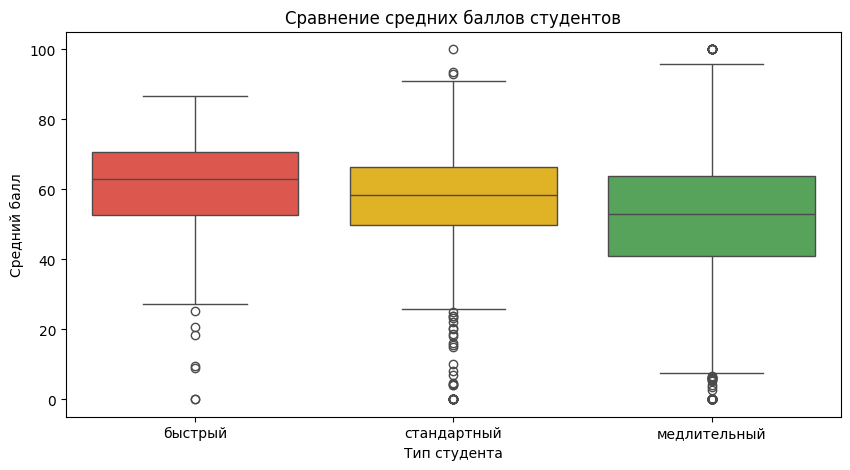

In [13]:
# Визуализация
plt.figure(figsize=(10, 5))
# Создание boxplot
sns.boxplot(
    x='student_type',   # Ось X: категории "быстрый"/"стандартный"/"медлительный"
    y='avg_mark',       # Ось Y: средний балл
    hue='student_type',
    data=df,            # Данные из DataFrame
    order=['быстрый', 'стандартный', 'медлительный'], # Порядок групп на графике
    palette=['#4CAF50', '#FFC107', '#F44336'],
    legend=False  # Отключаем легенду, чтобы не было дублирования
)
# Добавляем заголовки и подписи
plt.title('Сравнение средних баллов студентов')
plt.xlabel('Тип студента')
plt.ylabel('Средний балл')

# Показываем график
plt.show()


## 4. Статистический анализ различий между группами

In [14]:
#Найдем средние баллы для каждой категории студентов
fast_mean = df[df['student_type'] == 'быстрый']['avg_mark'].mean()
standard_mean = df[df['student_type'] == 'стандартный']['avg_mark'].mean()
slow_mean = df[df['student_type'] == 'медлительный']['avg_mark'].mean()
print(f"'Быстрые': средний балл = {fast_mean:.2f}")
print(f"'Стандартные': средний балл = {standard_mean:.2f}")
print(f"'Медлительные': средний балл = {slow_mean:.2f}")

'Быстрые': средний балл = 59.43
'Стандартные': средний балл = 56.86
'Медлительные': средний балл = 50.98


### Результаты:
- Быстрые: 59.43
- Стандартные: 56.86  
- Медлительные: 50.98

Разница между группами видна, но нужно проверить статистическую значимость.

## 4.1. Проверка значимости различий (ANOVA)

In [15]:
from scipy.stats import f_oneway

# Разделяем данные на группы
fast = df[df['student_type'] == 'быстрый']['avg_mark']
standard = df[df['student_type'] == 'стандартный']['avg_mark']
slow = df[df['student_type'] == 'медлительный']['avg_mark']

# Проводим тест
f_stat, p_value = f_oneway(fast, standard, slow)
print(f"ANOVA p-value: {p_value:.4f}")

# Интерпретация
if p_value < 0.05:
    print("Разница статистически значима (гипотеза подтверждена)")
else:
    print("Разница незначима (возможно, случайна)")

ANOVA p-value: 0.0000
Разница статистически значима (гипотеза подтверждена)


### Вывод:
Гипотеза подтверждена (p < 0.05) - существуют статистически значимые различия между хотя бы двумя группами.

Теперь проверим попарные сравнения.

## 4.2. Попарные сравнения (t-тесты)

In [5]:
from scipy.stats import ttest_ind

# Сравниваем каждую пару групп
t1, p1 = ttest_ind(fast, standard)
t2, p2 = ttest_ind(fast, slow)
t3, p3 = ttest_ind(standard, slow)

print(f"Быстрые vs Стандартные: p-value = {p1:.4f}")
print(f"Быстрые vs Медленные: p-value = {p2:.4f}")
print(f"Стандартные vs Медленные: p-value = {p3:.4f}")

Быстрые vs Стандартные: p-value = 0.0907
Быстрые vs Медленные: p-value = 0.0000
Стандартные vs Медленные: p-value = 0.0000


### Результаты попарных сравнений:
1. Быстрые vs Стандартные: p = 0.0907 (разница незначима)  
2. Быстрые vs Медленные: p < 0.001 (разница значима)  
3. Стандартные vs Медленные: p < 0.001 (разница значима)

## 4.3. Размер эффекта (Cohen's d)

In [6]:
import numpy as np
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

print(f"Cohen’s d (Быстрые vs Стандартные): {cohens_d(fast, standard):.2f}")
print(f"Cohen’s d (Быстрые vs Медленные): {cohens_d(fast, slow):.2f}")
print(f"Cohen’s d (Стандартные vs Медленные): {cohens_d(standard, slow):.2f}")

Cohen’s d (Быстрые vs Стандартные): 0.16
Cohen’s d (Быстрые vs Медленные): 0.46
Cohen’s d (Стандартные vs Медленные): 0.33


### Интерпретация эффектов:
1. Быстрые vs Стандартные: 0.16 (малый эффект)  
2. Быстрые vs Медленные: 0.46 (средний эффект)  
3. Стандартные vs Медленные: 0.33 (малый/средний эффект)

## 5. Рекомендации

1. **Для медлительных студентов**:
   - Внедрить систему ранних напоминаний
   - Разбивать сложные задания на подзадачи
   - Ввести бонусы за своевременную сдачу

2. **Для всех групп**:
   - Оптимизировать дедлайны (например, 72 часа вместо 48)
   - Ввести градацию сложности заданий

3. **Метрики для контроля**:
   - Еженедельно отслеживать среднее время сдачи
   - Мониторить разницу в успеваемости между группами